# **Load The Dataset**

In [3]:
!pip install ucimlrepo

In [4]:
from ucimlrepo import fetch_ucirepo


bank_marketing = fetch_ucirepo(id=222)


X = bank_marketing.data.features
y = bank_marketing.data.targets


print(bank_marketing.metadata)
print(bank_marketing.variables)


{'uci_id': 222, 'name': 'Bank Marketing', 'repository_url': 'https://archive.ics.uci.edu/dataset/222/bank+marketing', 'data_url': 'https://archive.ics.uci.edu/static/public/222/data.csv', 'abstract': 'The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 45211, 'num_features': 16, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Occupation', 'Marital Status', 'Education Level'], 'target_col': ['y'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2014, 'last_updated': 'Fri Aug 18 2023', 'dataset_doi': '10.24432/C5K306', 'creators': ['S. Moro', 'P. Rita', 'P. Cortez'], 'intro_paper': {'ID': 277, 'type': 'NATIVE', 'title': 'A data-driven approach to predict the s

# **Data Preprocessing**

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch
from torch.utils.data import DataLoader, TensorDataset
# Encode target (yes/no -> 0/1)
y = LabelEncoder().fit_transform(y.values.ravel())

# Encode categorical features
X = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# **Define the Model**

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class NeuralNet(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

model = NeuralNet(X_train.shape[1])


# **Loss function & optimizer**

In [7]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# **Train the Model**

In [8]:
epochs = 20

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/20], Loss: 0.2478
Epoch [2/20], Loss: 0.2185
Epoch [3/20], Loss: 0.2133
Epoch [4/20], Loss: 0.2091
Epoch [5/20], Loss: 0.2053
Epoch [6/20], Loss: 0.2015
Epoch [7/20], Loss: 0.1991
Epoch [8/20], Loss: 0.1963
Epoch [9/20], Loss: 0.1936
Epoch [10/20], Loss: 0.1917
Epoch [11/20], Loss: 0.1898
Epoch [12/20], Loss: 0.1881
Epoch [13/20], Loss: 0.1861
Epoch [14/20], Loss: 0.1838
Epoch [15/20], Loss: 0.1823
Epoch [16/20], Loss: 0.1804
Epoch [17/20], Loss: 0.1791
Epoch [18/20], Loss: 0.1772
Epoch [19/20], Loss: 0.1753
Epoch [20/20], Loss: 0.1741


# **Final Evaluation**

In [9]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        predicted = (outputs > 0.5).float()
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 90.20%


In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

epochs = 30
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    # ---- Training ----
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # ---- Validation ----
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_running_loss += loss.item()

            predicted = (outputs > 0.5).float()
            val_total += targets.size(0)
            val_correct += (predicted == targets).sum().item()

    val_loss = val_running_loss / len(test_loader)
    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


Epoch [1/30] Train Loss: 0.1728, Train Acc: 92.24% | Val Loss: 0.2284, Val Acc: 90.11%
Epoch [2/30] Train Loss: 0.1717, Train Acc: 92.42% | Val Loss: 0.2298, Val Acc: 90.48%
Epoch [3/30] Train Loss: 0.1697, Train Acc: 92.52% | Val Loss: 0.2323, Val Acc: 90.29%
Epoch [4/30] Train Loss: 0.1679, Train Acc: 92.57% | Val Loss: 0.2377, Val Acc: 90.22%
Epoch [5/30] Train Loss: 0.1674, Train Acc: 92.68% | Val Loss: 0.2331, Val Acc: 90.12%
Epoch [6/30] Train Loss: 0.1661, Train Acc: 92.74% | Val Loss: 0.2325, Val Acc: 90.05%
Epoch [7/30] Train Loss: 0.1640, Train Acc: 92.86% | Val Loss: 0.2373, Val Acc: 90.35%
Epoch [8/30] Train Loss: 0.1633, Train Acc: 92.77% | Val Loss: 0.2434, Val Acc: 90.19%
Epoch [9/30] Train Loss: 0.1621, Train Acc: 92.86% | Val Loss: 0.2392, Val Acc: 89.78%
Epoch [10/30] Train Loss: 0.1603, Train Acc: 93.05% | Val Loss: 0.2415, Val Acc: 90.01%
Epoch [11/30] Train Loss: 0.1593, Train Acc: 93.07% | Val Loss: 0.2449, Val Acc: 90.10%
Epoch [12/30] Train Loss: 0.1581, Train A

# **Evaluation Metrics**

In [10]:
from sklearn.metrics import classification_report

y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        predicted = (outputs > 0.5).int()
        y_true.extend(targets.int().numpy())
        y_pred.extend(predicted.numpy())

print("Classification Report:")
print(classification_report(y_true, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.9301    0.9608    0.9452      7952
           1     0.6236    0.4739    0.5385      1091

    accuracy                         0.9020      9043
   macro avg     0.7769    0.7173    0.7419      9043
weighted avg     0.8931    0.9020    0.8961      9043



# **Training-Validation and  Accuracy/Loss plots.**

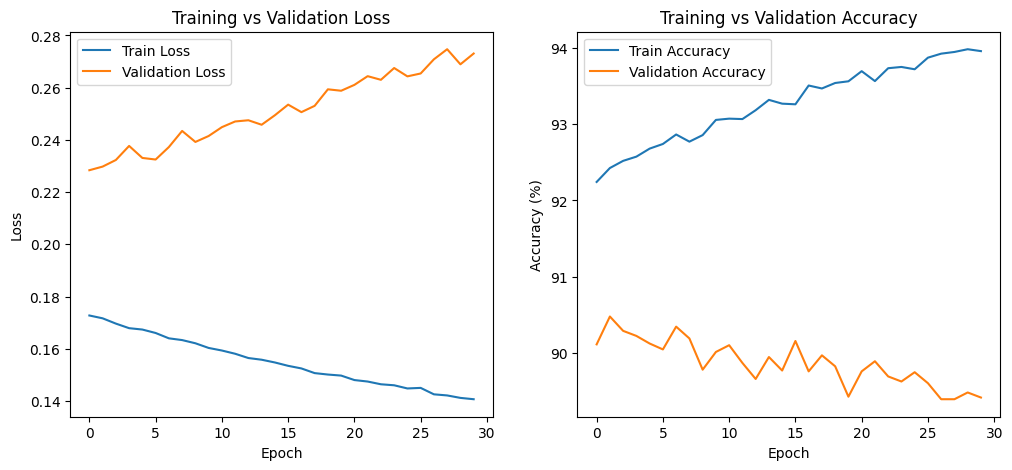

In [14]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12,5))

# Plot loss
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.show()

